### Can we classify each phase as relatively low or high anxiety for each subject? ###

In [2]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
import pandas as pd
import random
import scipy.signal as ss
import shap
import sys
sys.path.append(module_path)

import tools.data_reader_wesad as dr
import tools.display_tools as dt
import tools.preprocessing as preprocessing
import train

from scipy.fft import fft, fftfreq, fftshift
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)


phases = dr.Phases.PHASE_ORDER


c:\Users\zhoux\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
models = {
    # "SVM": SVC(C=10, gamma=1),  # C=10, gamma=1
    # "KNN": KNeighborsClassifier(n_neighbors=7),
    # "DT": DecisionTreeClassifier(),
    "LogReg": LogisticRegression(max_iter=1000),
    # "Bayes": GaussianNB(),
    "RF": RandomForestClassifier(n_estimators=50, max_features=3),
    "XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="error")
}

y_train | y_test:
{0: 42, 1: 13} | {0: 13, 1: 2}
y_train | y_test:
{0: 43, 1: 12} | {0: 12, 1: 3}
y_train | y_test:
{0: 44, 1: 11} | {0: 11, 1: 4}
y_train | y_test:
{0: 44, 1: 11} | {0: 11, 1: 4}
y_train | y_test:
{0: 47, 1: 13} | {0: 8, 1: 2}
Fold #0
Model LogReg, Predictions: [0 1], [14  1]


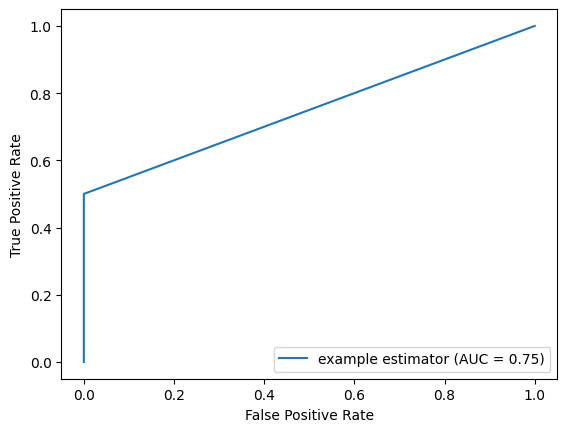

Fold #1
Model LogReg, Predictions: [0], [15]


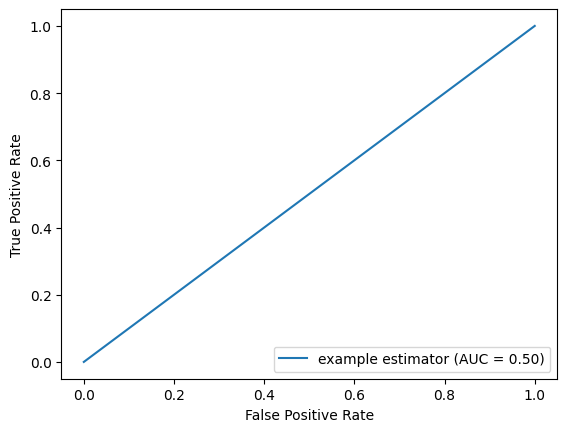

Fold #2
Model LogReg, Predictions: [0], [15]


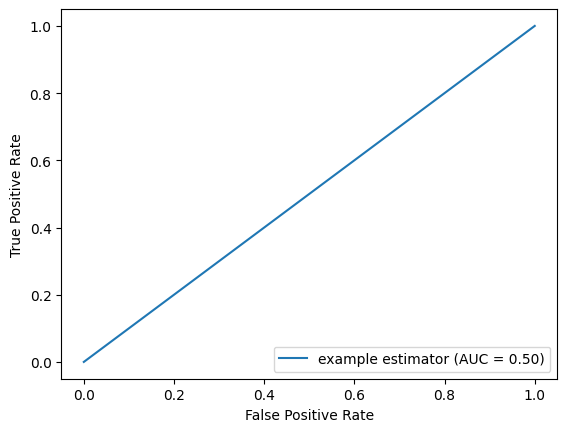

Fold #3
Model LogReg, Predictions: [0], [15]


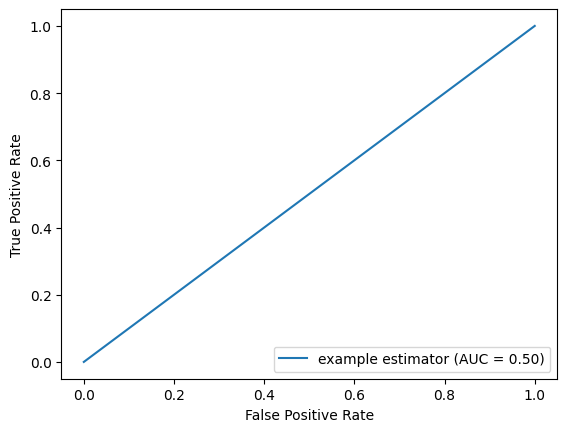

Fold #4
Model LogReg, Predictions: [0], [10]


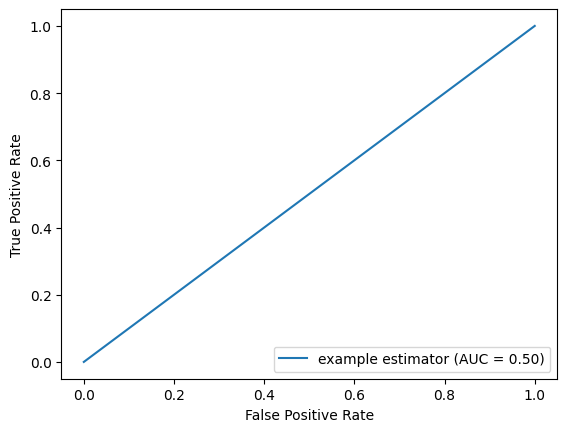

Fold #0
Model RF, Predictions: [0 1], [11  4]


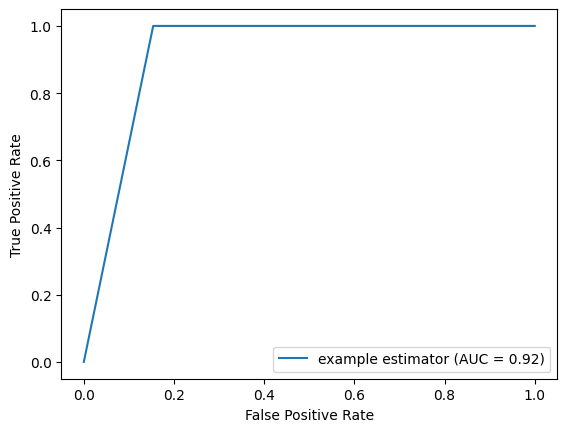

Fold #1
Model RF, Predictions: [0 1], [14  1]


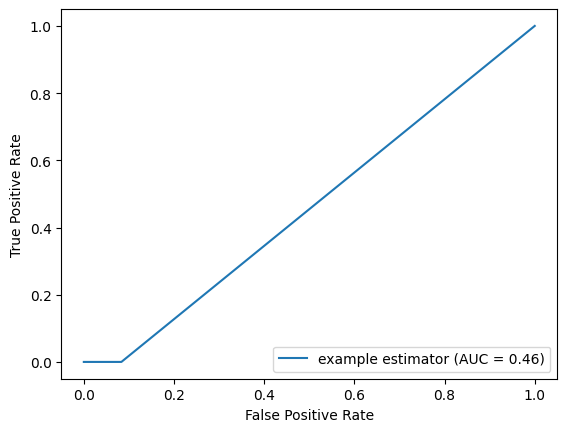

Fold #2
Model RF, Predictions: [0 1], [13  2]


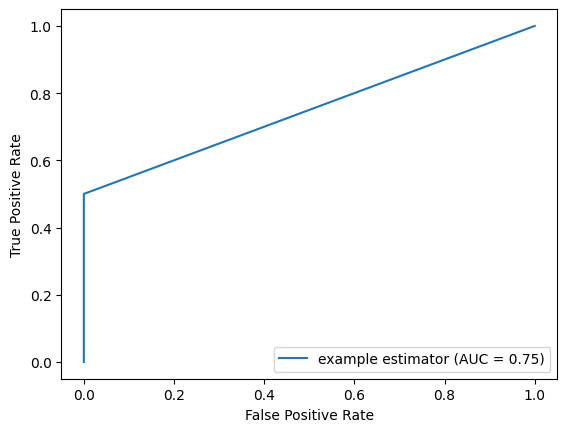

Fold #3
Model RF, Predictions: [0 1], [12  3]


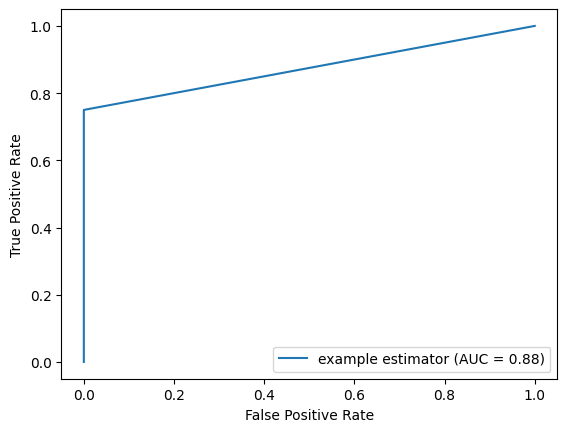

Fold #4
Model RF, Predictions: [0 1], [9 1]


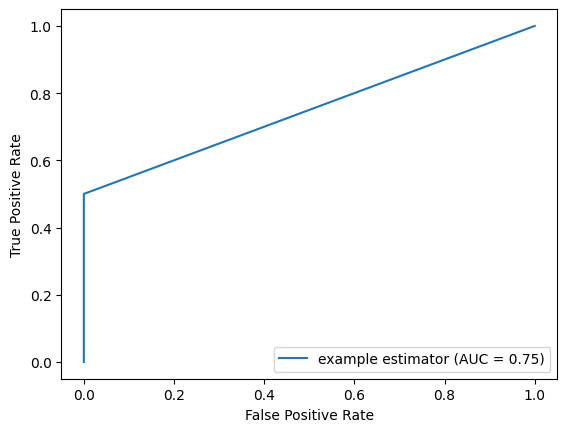

Fold #0
Model XGB, Predictions: [0 1], [11  4]


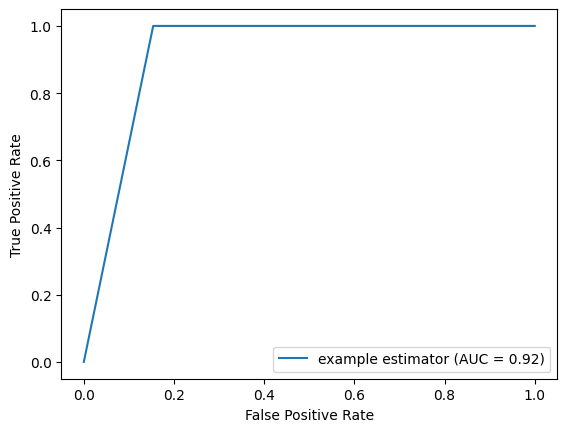

Fold #1
Model XGB, Predictions: [0 1], [13  2]


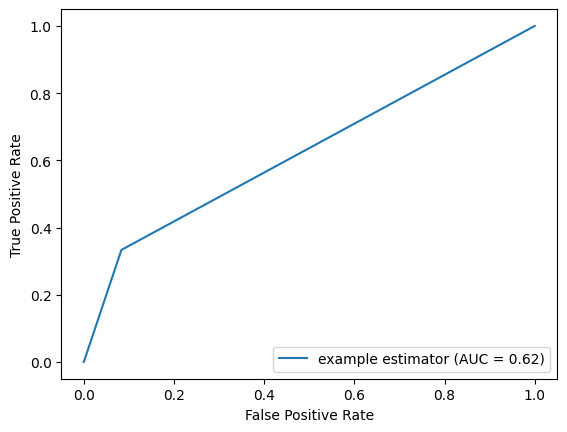

Fold #2
Model XGB, Predictions: [0 1], [13  2]


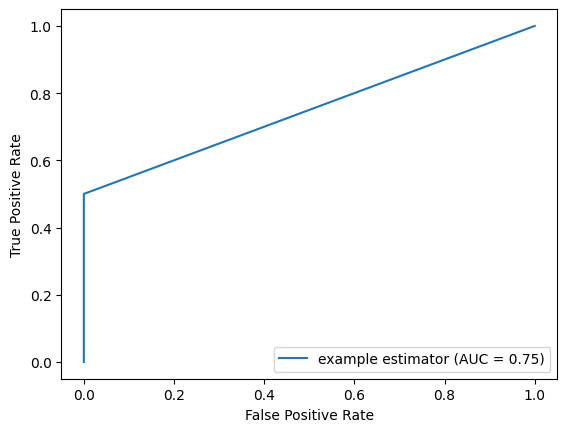

Fold #3
Model XGB, Predictions: [0 1], [13  2]


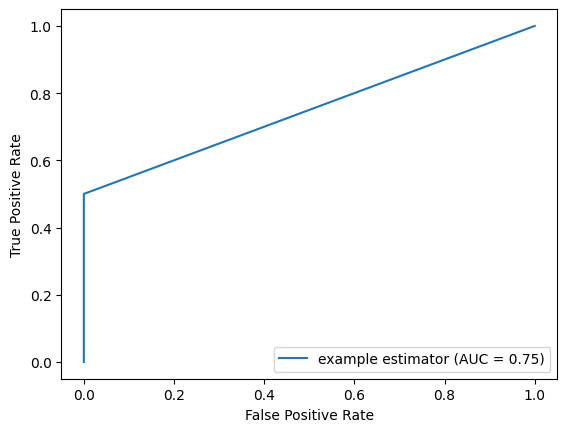

Fold #4
Model XGB, Predictions: [0 1], [9 1]


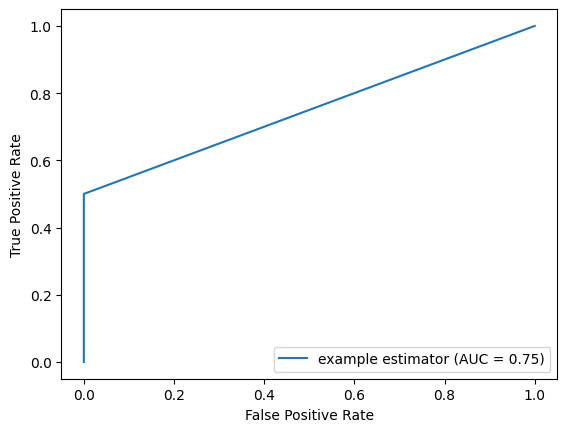


[('bpm', 1.8515574386982594), ('mean_SCL', 1.105511707644187), ('lf_rr', 0.757008015570237), ('SCR_rate', 0.6489893342146799), ('rmssd', 0.12068816252993421), ('hf_rr', 0.06462764233796932), ('sdnn', -0.24258068168675037), ('lf_hf_ratio', -0.521600442237839)]
[('bpm', 1.7303534161215643), ('mean_SCL', 1.2963115338951245), ('lf_rr', 0.7562364117292516), ('SCR_rate', 0.6745818215540073), ('rmssd', 0.48029266188352066), ('hf_rr', 0.12002478359419397), ('sdnn', -0.16467215041065536), ('lf_hf_ratio', -0.5693513234453264)]
[('bpm', 1.988573063040916), ('SCR_rate', 0.7996767673467703), ('mean_SCL', 0.7585093238914075), ('lf_rr', 0.6989472195808126), ('rmssd', 0.321343106715768), ('hf_rr', 0.09673134745273584), ('sdnn', -0.26009466558272515), ('lf_hf_ratio', -0.3350100408196578)]
[('bpm', 1.7483242448010352), ('mean_SCL', 0.9035703439607701), ('SCR_rate', 0.9022281953756404), ('lf_rr', 0.6282822715561469), ('hf_rr', 0.27234937991216557), ('rmssd', 0.18990730505782108), ('sdnn', -0.42717010794

In [6]:
importlib.reload(train)
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)


metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    # train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE, 
]

model_phases = dr.Phases.PHASE_ORDER

label_type = "stai"
threshold = "fixed"

x, y = train.Train_WESAD.get_wesad_data(metrics, model_phases, verbose=False, label_type=label_type, threshold=threshold, normalize=True)
x = x.drop(["phaseId"], axis=1)

acc_results = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
reports = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
num_iters = 1
get_importance = True
for _ in range(num_iters):
    out = train.train_predict(models, x, y, by_subject=True, save_metrics=True, is_resample=False, get_importance=get_importance, drop_subject=True, test_size=0.2, folds=5)
    for model_name in acc_results:
        for i in range(len(out[model_name])):
            acc_results[model_name].append(out[model_name][i][0])
            reports[model_name].append(out[model_name][i][1])
        if get_importance:
            try:
                print("")
                # shap.plots.bar(out[model_name][0][2])
                for i in range(len(out[model_name])):
                    feature_imp = list(zip(metrics + ["lf_hf_ratio"], out[model_name][i][2]))
                    feature_imp = sorted(feature_imp, key=lambda x: x[1], reverse=True)
                    print(feature_imp)
            except Exception as e:
                print(out[model_name][0][2])
            print("")

for model_name in acc_results.keys():
    print(f"Model evaluation metrics for {model_name}:")
    for i in range(len(reports[model_name])):
        report = reports[model_name][i]
        acc = acc_results[model_name][i]
        p = report["precision"]
        r = report["recall"]
        f1 = report["f1"]
        auc = report["auc"]
        print(f"\tAccuracy: {acc}\n\tPrecision: {p}\n\tRecall: {r}\n\tF1-score: {f1}\n\tAUC score: {auc}\n" + "-"*40)
    print("")
print("\n")